In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "crop-damage-classification"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/crop-damage-classification
common		    data	 Index_bc.py  models	  preprocess_input.py	run.yaml
config.yaml	    dataloading  Index.ipynb  output	  project-structure.md	transforms
corrupt_files.json  experiments  index.py     preprocess  README.md		visualization


In [ ]:
# set up environment
# comment if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

# Following cells are for downloading data

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# comment if not required
!pip install boto3
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.2 MB/s eta 0:00:00


In [3]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor, Resize, CenterCrop
from dataloading.dataset import CropDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_modelinfo, get_saved_model, read_json, insert_index_2csv, get_model_data
from models.resnet18 import Resnet18
from models.custom_models import get_model
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester
from preprocess.preprocessor import Preprocessor
from tqdm import tqdm

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
import boto3
from pathlib import Path
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm

def get_file_folders(s3_client, bucket_name, prefix=""):
    file_names = []
    folders = []

    default_kwargs = {
        "Bucket": bucket_name,
        "Prefix": prefix
    }
    next_token = ""

    while next_token is not None:
        updated_kwargs = default_kwargs.copy()
        if next_token != "":
            updated_kwargs["ContinuationToken"] = next_token

        response = s3_client.list_objects_v2(**updated_kwargs)
        contents = response.get("Contents")

        for result in contents:
            key = result.get("Key")
            if key[-1] == "/":
                folders.append(key)
            else:
                file_names.append(key)

        next_token = response.get("NextContinuationToken")

    return file_names, folders

def download_files(s3_client, bucket_name, local_path, file_names, folders):
    local_path = Path(local_path)

    for folder in tqdm(folders):
        folder_path = Path.joinpath(local_path, folder)
				# Create all folders in the path
        folder_path.mkdir(parents=True, exist_ok=True)

    for file_name in tqdm(file_names):
        file_path = Path.joinpath(local_path, file_name)
				# Create folder for parent directory
        file_path.parent.mkdir(parents=True, exist_ok=True)
        s3_client.download_file(
            bucket_name,
            file_name,
            str(file_path)
        )

data_path = 'data/input/images'
if not(os.path.exists(os.path.join(os.getcwd(), data_path))):
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    file_names, folders = get_file_folders(client, 'cgiar-crop-damage-classification-challenge')
    download_files(
        client,
        'cgiar-crop-damage-classification-challenge',
        "/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input",
        file_names,
        folders
    )

In [4]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'image', 'data_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data', 'device': 'cpu', 'img_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input/images', 'output_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification', 'use_gpu': False, 'y_key': 'label'}


In [ ]:
#clean up invalid images

'''
from PIL import Image, UnidentifiedImageError
import json
import pandas as pd

image_files = os.listdir(os.path.join(config['root_dir'],'data/input/images'))
corrupt_files = []
print('scanning files for corrupt images\n\n')
for img_file in tqdm(image_files):
    try:
        img = Image.open(os.path.join(config['img_dir'], img_file))
    except UnidentifiedImageError as e:
        if os.path.exists(os.path.join(config["data_dir"], img_file)):
            os.remove(os.path.join(config["data_dir"], img_file))
        corrupt_files.append(img_file)
#corrupt_files = ['c3092a5186771280a99200624c4f67e33fde95ca.jpg']
data = { "data": corrupt_files }
with open('corrupt_files.json', 'w') as fp:
    json.dump(data, fp)

train_path = os.path.join(config['data_dir'], 'input/Train.csv')
train_df = pd.read_csv(train_path)
error_rows = train_df.loc[train_df['filename'].isin(corrupt_files)].index.tolist()
train_df = train_df.drop(labels = error_rows)
train_df.to_csv(train_path, index = False)
'''

'\nfrom PIL import Image, UnidentifiedImageError\nimport json\nimport pandas as pd\n\nimage_files = os.listdir(os.path.join(config[\'root_dir\'],\'data/input/images\'))\ncorrupt_files = []\nprint(\'scanning files for corrupt images\n\n\')\nfor img_file in tqdm(image_files):\n    try:\n        img = Image.open(os.path.join(config[\'img_dir\'], img_file))\n    except UnidentifiedImageError as e:\n        if os.path.exists(os.path.join(config["data_dir"], img_file)):\n            os.remove(os.path.join(config["data_dir"], img_file))\n        corrupt_files.append(img_file)\n#corrupt_files = [\'c3092a5186771280a99200624c4f67e33fde95ca.jpg\']\ndata = { "data": corrupt_files }\nwith open(\'corrupt_files.json\', \'w\') as fp:\n    json.dump(data, fp)\n\ntrain_path = os.path.join(config[\'data_dir\'], \'input/Train.csv\')\ntrain_df = pd.read_csv(train_path)\nerror_rows = train_df.loc[train_df[\'filename\'].isin(corrupt_files)].index.tolist()\ntrain_df = train_df.drop(labels = error_rows)\ntrain

In [5]:
# insert index column to label csvs
insert_index_2csv(os.path.join(config['data_dir'], 'input/Train.csv'))
insert_index_2csv(os.path.join(config['data_dir'], 'input/Test.csv'))

In [6]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 350, 'crop_dim': 256}, 'train': {'shuffle_data': False, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'cross-entropy', 'epoch_interval': 1, 'num_epochs': 30}, 'model': {'name': 'resnet18', 'optimizer': 'Adam', 'lr': 0.01, 'weight_decay': 1e-05, 'amsgrad': False, 'momentum': 0.85}, 'test_model': False}


In [7]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [8]:
#preprocess data or load preprocessed data

#build label dict
label_dict = {
    'DR': 0,
    'G': 1,
    'ND': 2,
    'WD': 3,
    'other': 4
}

class_dict = {
    0: 'DR',
    1: 'G',
    2: 'ND',
    3: 'WD',
    4: 'other'
}

In [9]:
#save X_key and y_key
save2config('X_key', 'image')
save2config('y_key', 'label')

#transform data
data_transforms = [ToTensor(), Resize(exp_params['transform']['resize_dim']), CenterCrop(exp_params['transform']['crop_dim'])]

#convert to dataset
ftr_dataset = CropDataset('input/Train.csv', label_dict, False)
test_dataset = CropDataset('input/Test.csv', label_dict, True)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smtelen = int(0.01 * len(test_dataset))
smfte_dataset = torch.utils.data.Subset(test_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(test_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')



Full train dataset length: 26068
Test dataset length: 8663
Subset train dataset length: 260
Subset test dataset length: 86 



In [ ]:
'''
print("Getting metrics for small data")
preop = Preprocessor()
all_folds_metrics = preop.get_dataset_metrics(smftr_dataset, data_transforms)
print(all_folds_metrics)
'''

'\nprint("Getting metrics for small data")\npreop = Preprocessor()\nall_folds_metrics = preop.get_dataset_metrics(smftr_dataset, data_transforms)\nprint(all_folds_metrics)\n'

In [ ]:
'''
#running experiment on small subset of the dataset
all_folds_metrics = read_json(os.path.join(config['root_dir'], 'models/checkpoints/all_folds_metrics.json'))
all_folds_metrics = {int(k): v for k,v in all_folds_metrics.items()}
print(all_folds_metrics)
print('\n\n')

exp = Experiment(exp_params['model']['name'], smftr_dataset, data_transforms, all_folds_metrics)
model_history = exp.train()
'''

"\n#running experiment on small subset of the dataset\nall_folds_metrics = read_json(os.path.join(config['root_dir'], 'models/checkpoints/all_folds_metrics.json'))\nall_folds_metrics = {int(k): v for k,v in all_folds_metrics.items()}\nprint(all_folds_metrics)\nprint('\n\n')\n\nexp = Experiment(exp_params['model']['name'], smftr_dataset, data_transforms, all_folds_metrics)\nmodel_history = exp.train()\n"

In [ ]:
'''
print("Getting metrics for data")
preop = Preprocessor()
all_folds_metrics = preop.get_dataset_metrics(ftr_dataset, data_transforms)
print(all_folds_metrics)
'''

'\nprint("Getting metrics for data")\npreop = Preprocessor()\nall_folds_metrics = preop.get_dataset_metrics(ftr_dataset, data_transforms)\nprint(all_folds_metrics)\n'

In [11]:
print(len(os.listdir("data/input/images")))

34906


In [10]:
#model training on full dataset
all_folds_metrics = read_json(os.path.join(config['root_dir'], 'models/checkpoints/all_folds_metrics.json'))
all_folds_metrics = {int(k): v for k,v in all_folds_metrics.items()}
print(all_folds_metrics)
print('\n\n')

exp = Experiment(exp_params['model']['name'], ftr_dataset, data_transforms, all_folds_metrics)
model_history = exp.train()

{0: {'mean': [0.0017170946972042906, 0.0017039978036693499, 0.0012039661407470704], 'std0': [0.0009368337836920046, 0.0009318411934609507, 0.00105056552325978]}}



Loading saved model
{'valloss': 0.9241737685733168, 'valacc': tensor(0.6167), 'trloss': 0.9253037379160113, 'trlosshistory': tensor([1.1958, 1.0514, 0.9997, 0.9647, 0.9413, 0.9253]), 'vallosshistory': tensor([1.0756, 1.0620, 0.9637, 0.9549, 1.0559, 0.9242]), 'valacchistory': tensor([0.4709, 0.4863, 0.5816, 0.5868, 0.5327, 0.6167]), 'fold': -1, 'epoch': 5}



Running straight split
	Running Epoch 6


		Running through training set:   0%|          | 0/163 [02:00<?, ?it/s]


OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input/images/5061ae056784f70e6ed32a3d41789f23025a3cf5.jpg'

All folds metrics
{'0': {'mean': [0.0017170946972042906, 0.0017039978036693499, 0.0012039661407470704], 'std0': [0.0009368337836920046, 0.0009318411934609507, 0.00105056552325978]}}

Model validation results
[20.154714584350586, 1.0772416591644287, 1.0758166313171387, 1.0615193843841553, 1.0148066282272339, 1.0135291814804077, 0.99669349193573, 1.0166503190994263, 0.9963307976722717, 0.9410083293914795, 0.9333593845367432, 0.9244870543479919, 0.8942120671272278, 0.7905331254005432, 0.8510660529136658, 0.9806917309761047, 0.976203203201294, 0.8027191162109375, 0.7868804931640625, 0.8847337961196899, 0.9376339912414551, 0.7697225213050842, 0.7413023114204407, 0.8116212487220764, 0.8865652084350586, 0.9355958104133606, 0.7999270558357239, 0.7981638312339783, 0.8222689032554626, 0.7173763513565063]

Best model results




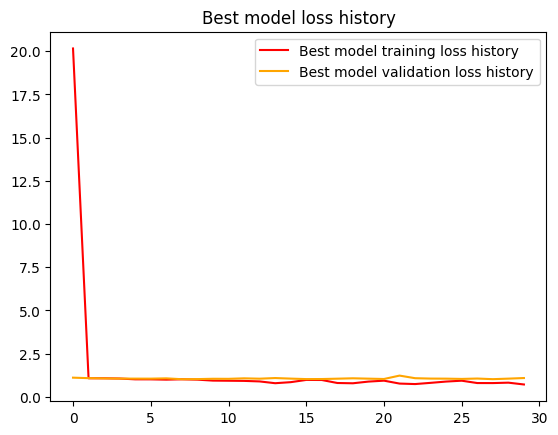

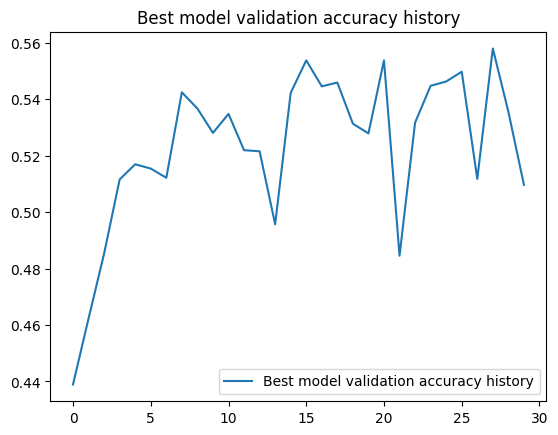


Best Model Training Loss: 0.7173763304441503
Best Model Validation Loss: 1.0901295209077322
Best Model Accuracy: 0.5096873044967651


Training Loss	Validation Loss	Validation Accuracy
0.7173763304441503	1.0901295209077322	0.5096873044967651


In [18]:
# get best model
model = get_model(exp_params["model"]["name"])
model = get_saved_model(model, '')
model_info = get_modelinfo('')
_, model_history, _ = get_model_data('')
best_fold = model_info['results']['fold']
metric_path = os.path.join(config["root_dir"], "models/checkpoints/all_folds_metrics.json")
all_folds_metrics = read_json(metric_path)
print('All folds metrics')
print(all_folds_metrics)

print("\nModel validation results")
print(model_info['results']['trlosshistory'])
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()

In [ ]:
'''
#model testing on small test dataset
print("\n\nTesting Saved Model")
metrics = all_folds_metrics[f'{best_fold}']
mt = ModelTester(model, smfte_dataset, data_transforms, metrics)
mt.test_and_save_csv(class_dict)
'''

In [19]:
#model testing on test dataset
print("\n\nTesting Saved Model")
metrics = all_folds_metrics[f'{best_fold}']
mt = ModelTester(model, test_dataset, data_transforms, metrics)
mt.test_and_save_csv(class_dict)



Testing Saved Model


Running through test dataset: 100%|██████████| 68/68 [06:32<00:00,  5.77s/it]
